# Playground Script
### -- Moritz

### Libraries

In [41]:
import os
import requests
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as F

import ultralytics
from ultralytics import YOLO
from ultralytics.data import converter

In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [21]:
import gdown

id = "10DXgjv9c7TONGhE38oI5oHTWff8NJmJn"
output = "yolov8_medium_20e.pt"
gdown.download(id=id, output=output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10DXgjv9c7TONGhE38oI5oHTWff8NJmJn 



In [13]:
type(output)

str

### Notes

- Train test split:
    - Split: 70 / 20 / 10
    - => 1780 + 508 + 254 images and labels in train/test/split

## Load Dataset

In [22]:
# URLs of the files to download
url1 = "https://zenodo.org/records/7358126/files/bdappv.zip?download=1"
url2 = "https://zenodo.org/records/7358126/files/data.zip?download=1"

# Define dataset name
dataset_name = "kasmi_solar"

# Define the directory to save the files in
save_dir = f"data/{dataset_name}"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Download the files
os.system(f'wget -O {os.path.join(save_dir, "bdappv.zip")} {url1}')
os.system(f'wget -O {os.path.join(save_dir, "data.zip")} {url2}')

--2024-01-15 16:28:45--  https://zenodo.org/records/7358126/files/data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17716478 (17M) [application/octet-stream]
Saving to: ‘data/kasmi_solar/data.zip’

     0K .......... .......... .......... .......... ..........  0%  764K 23s
    50K .......... .......... .......... .......... ..........  0% 1,29M 18s
   100K .......... .......... .......... .......... ..........  0% 7,91M 13s
   150K .......... .......... .......... .......... ..........  1% 6,98M 10s
   200K .......... .......... .......... .......... ..........  1% 1,31M 10s
   250K .......... .......... .......... .......... ..........  1% 6,44M 9s
   300K .......... .......... .......... .......... ..........  2% 6,35M 8s
   350K .......... .......... .......... .......... ..........  2% 7,14M 7s
   400K

0

In [23]:
!unzip data/{dataset_name}/data.zip -d data/{dataset_name}
# delete the zip file
#!rm data/{dataset_name}/data.zip
 
!unzip data/{dataset_name}/bdappv.zip -d data/{dataset_name}
# delete the zip file
#!rm data/{dataset_name}/bdappv.zip

Archive:  data/kasmi_solar/data.zip
   creating: data/kasmi_solar/data/
   creating: data/kasmi_solar/data/raw/
  inflating: data/kasmi_solar/data/raw/input-google.json  
  inflating: data/kasmi_solar/data/raw/input-ign.json  
  inflating: data/kasmi_solar/data/raw/raw-metadata.csv  
   creating: data/kasmi_solar/data/replication/
   creating: data/kasmi_solar/data/replication/campaign-google/
  inflating: data/kasmi_solar/data/replication/campaign-google/click-analysis.json  
  inflating: data/kasmi_solar/data/replication/campaign-google/polygon-analysis.json  
   creating: data/kasmi_solar/data/replication/campaign-ign/
  inflating: data/kasmi_solar/data/replication/campaign-ign/click-analysis.json  
  inflating: data/kasmi_solar/data/replication/campaign-ign/polygon-analysis.json  
   creating: data/kasmi_solar/data/validation/
   creating: data/kasmi_solar/data/validation/campaign-google/
  inflating: data/kasmi_solar/data/validation/campaign-google/click-analysis-thres=1.0.json  


The dataset is composed of images, some of which feature solar panels and others do not. For those images that do contain solar panels, corresponding mask PNG files are provided. However, for images without solar panels, no such mask files exist.

In [24]:
# Define the path to the image folder
img_folder = f"data/{dataset_name}/bdappv/google/img"

# Define the path to the mask folder
mask_folder = f"data/{dataset_name}/bdappv/google/mask"

# Get a list of all files in the image folder
img_files = os.listdir(img_folder)

# Get a list of all files in the mask folder
mask_files = os.listdir(mask_folder)

# Count the number of files in the image folder
num_img_files = len(img_files)

# Count the number of files in the mask folder
num_mask_files = len(mask_files)

# Print the number of files in the image folder
print(f"Number of files in {img_folder}: {num_img_files}")

# Print the number of files in the mask folder
print(f"Number of files in {mask_folder}: {num_mask_files}")

Number of files in data/kasmi_solar/bdappv/google/img: 28807
Number of files in data/kasmi_solar/bdappv/google/mask: 13303


## File Organization

### Draw Bounding Boxes

In [28]:
# Read in an image and its mask
IMAGE_DIRECTORY = "data/kasmi_solar/bdappv/google"

img_path = os.path.join(IMAGE_DIRECTORY, "img/AAKEG5A92ACPSX.png")
mask_path = os.path.join(IMAGE_DIRECTORY, "mask/AAKEG5A92ACPSX.png")

img = read_image(img_path, mode=ImageReadMode.RGB)
mask = read_image(mask_path, mode=ImageReadMode.GRAY)

torch.Size([3, 400, 400])
torch.Size([1, 400, 400])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


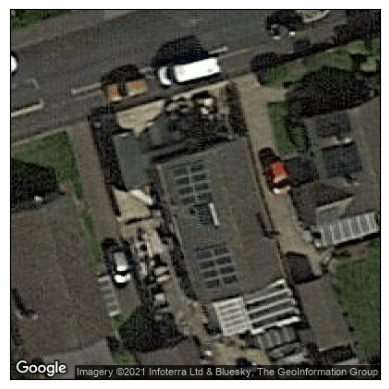

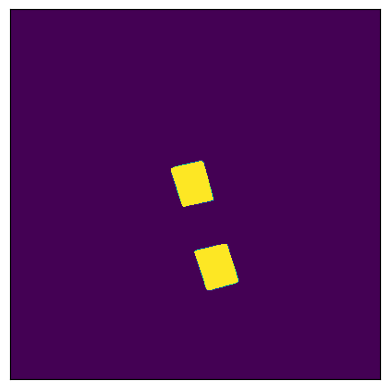

In [10]:
print(img.size())
print(mask.size())
print(mask)

show(img)
show(mask)

In [11]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]

In [12]:
print(masks.size())
print(masks)

torch.Size([1, 400, 400])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


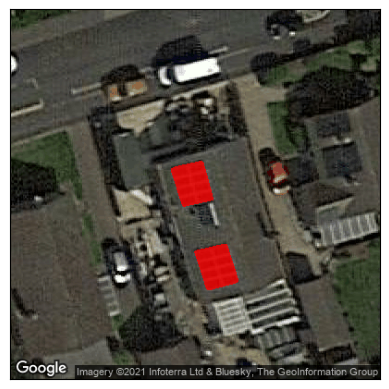

In [13]:
drawn_mask = draw_segmentation_masks(img, masks, alpha=0.8, colors="red")

show(drawn_mask)

### Convert Masks to Bounding Boxes

In [25]:
# Define image width and height
IMG_WIDTH = IMG_HEIGHT = 400

In [26]:
def bboxes_yolo(bbox):
    x_center = ((bbox[0] + bbox[2]) / 2) / IMG_WIDTH
    y_center = ((bbox[1] + bbox[3]) / 2) / IMG_HEIGHT
    box_width = (bbox[2] - bbox[0]) / IMG_WIDTH
    box_height = (bbox[3] - bbox[1]) / IMG_HEIGHT

    bbox_yolo = (x_center, y_center, box_width, box_height)
    return bbox_yolo


def bboxes_albumentations(bbox):
    bbox_normalized = np.empty(4, dtype="float")
    bbox_normalized[[1, 3]] = bbox[[1, 3]] / IMG_HEIGHT
    bbox_normalized[[0, 2]] = bbox[[0, 2]] / IMG_WIDTH
    return bbox_normalized

In [29]:
# Masks to bounding boxes
tensor_box = masks_to_boxes(mask)
box = tensor_box.numpy()[0]  # transform to ndarray
box  # (x1, y1, x2, y2) format

array([        174,         164,         246,         303], dtype=float32)

In [30]:
bbox_norm = bboxes_albumentations(box)
bbox_norm

array([      0.435,        0.41,       0.615,      0.7575])

In [31]:
bbox_yolo = bboxes_yolo(box)
bbox_yolo

(0.525, 0.58375, 0.18, 0.3475)

In [31]:
mask_files = os.listdir("data/kasmi_solar/bdappv/google/mask/")

try:
    os.makedirs("data/kasmi_solar/bdappv/google/labels", exist_ok=False)
except OSError:
    pass

In [32]:
mask_files = os.listdir("data/kasmi_solar/bdappv/google/mask/")
try:
    os.makedirs("data/kasmi_solar/bdappv/google/labels", exist_ok=False)
except OSError:
    pass

for i in range(0, len(mask_files)):
    mask_path = "data/kasmi_solar/bdappv/google/mask/" + mask_files[i]
    mask = read_image(mask_path, mode=ImageReadMode.GRAY)

    tensor_box = masks_to_boxes(mask)
    box = tensor_box.numpy()[0]  # transform to ndarray

    bbox_yolo = bboxes_yolo(box)

    class_label = "0"
    bbox_label = (
        class_label + " " + " ".join(map(str, bbox_yolo))
    )  # add a class to the label

    picture_ID = str.strip(mask_files[i], ".png")
    label_path = "data/kasmi_solar/bdappv/google/labels/" + picture_ID + ".txt"
    with open(label_path, "w") as file:
        file.write(bbox_label)

### Separate Images with Solar Panels from Images w/o Panels

In [34]:
all_images = os.listdir(f"data/{dataset_name}/bdappv/google/img/")
images_with_masks = os.listdir(f"data/{dataset_name}/bdappv/google/mask/")
images_without_masks = [x for x in all_images if x not in images_with_masks]

len(images_without_masks + images_with_masks) == len(all_images)

True

In [318]:
source = "data/kasmi_solar/bdappv/google/img/"
destination = "data/kasmi_solar/bdappv/google/img_with_panels/"

try:
    os.makedirs(destination, exist_ok=False)
except OSError:
    pass

for i in images_with_masks:
    shutil.copy(source + i, destination)

### Train-Test Split

In [37]:
import random

source_path_imgs = "data/kasmi_solar/bdappv/google/img_with_panels/"
imgs_list = os.listdir(source_path_imgs)
img_ids = [str.rstrip(i, ".png") for i in imgs_list]

In [38]:
# Split up image IDs

from sklearn.model_selection import train_test_split

train_ids, test_and_val_ids = train_test_split(
    img_ids, test_size=0.3, random_state=42
)  # train 0.7, test+val 0.3
test_ids, val_ids = train_test_split(
    test_and_val_ids, test_size=0.5, random_state=42
)  # test 0.15, val 0.15

print(len(train_ids), len(test_ids), len(val_ids))
print(len(train_ids) + len(test_ids) + len(val_ids))

9312 1995 1996
13303


In [39]:
# Define the path to the original files. The path includes the dataset name, which is assumed to be defined elsewhere.
origin_path = f"data/{dataset_name}/bdappv/google/"

# Define the path to the destination directories. The path includes the dataset name.
destination_path = f"datasets/{dataset_name}/"

# Define a dictionary with keys 'train', 'test', 'val' and values as lists of ids.
# These ids determine which files belong to the train, test, and validation sets, respectively.
# The lists train_ids, test_ids, and val_ids are assumed to be defined elsewhere.
ids_dict = {"train": train_ids, "test": test_ids, "val": val_ids}


def copy_files_to_yolo_dirs(origin_path, destination_path, ids_dict):
    """
    Copy images, labels, and masks to YOLO-organized directories.

    Parameters:
    origin_path (str): The path to the original files.
    destination_path (str): The path to the destination directories.
    ids_dict (dict): A dictionary with keys 'train', 'test', 'val' and values as lists of ids.
    """

    # Define the types of files to be copied. These are the subdirectories in the origin directory
    # that contain the files we want to copy.
    file_types = ["img_with_panels", "labels", "masks"]

    # We want to organize the files into 'train', 'test', and 'val' directories at the destination.
    # So, we loop over these dataset types.
    for dataset_type in ["train", "test", "val"]:
        # For each dataset type, we want to copy all types of files (images, labels, masks).
        # So, we loop over the file types.
        for file_type in file_types:
            # For each file type, we want to copy all files that belong to the current dataset type
            # (as indicated by the ids in ids_dict[dataset_type]). So, we loop over these ids.
            for i in ids_dict[dataset_type]:
                # The file extension depends on the file type. Images and masks are .png files,
                # while labels are .txt files. So, we set the extension accordingly.
                ext = ".png" if file_type != "labels" else ".txt"

                # We use shutil.copy to copy each file from the origin to the destination.
                # The paths to the origin and destination files are constructed using os.path.join.
                # The origin file is located in a subdirectory (file_type) of the origin directory,
                # and its name is the id (i) plus the extension.
                # The destination file is to be located in a subdirectory (file_type) of a subdirectory
                # (dataset_type) of the destination directory, and its name will be the same as the origin file.
                shutil.copy(
                    os.path.join(origin_path, file_type, f"{i}{ext}"),
                    os.path.join(destination_path, dataset_type, file_type),
                )

## Convert masks to Yolo format

In [62]:
import json  # Importing the json module to work with JSON data


def convert_polygons_to_txt(json_file, output_dir):
    # This function converts polygons from a JSON file to a TXT file

    with open(json_file, "r") as f:  # Open the JSON file in read mode
        data = json.load(f)  # Load the JSON data into a Python object

    for surface_result in data:  # Loop through each surface result in the data
        id = surface_result["id"]  # Get the ID of the surface result
        polygons = surface_result["polygons"]  # Get the polygons of the surface result

        filename = f"{id}.txt"  # Create a filename using the ID
        filepath = os.path.join(
            output_dir, filename
        )  # Create the full path to the output file

        with open(filepath, "w") as f:  # Open the output file in write mode
            for polygon in polygons:  # Loop through each polygon
                f.write("0")  # Write a "0" at the start of each line
                for point in polygon[
                    "points"
                ]:  # Loop through each point in the polygon
                    f.write(
                        f" {point['x']} {point['y']}"
                    )  # Write the x and y coordinates of the point
                f.write(
                    "\n"
                )  # Write a newline character to indicate the end of the polygon

In [63]:
convert_polygons_to_txt(
    f"data/{dataset_name}/data/validation/campaign-google/polygon-analysis-thres=1.0.json",
    f"datasets/{dataset_name}/masks",
)

## Modelling

### YOLOv8 Predictions

In [5]:
# Load the trained YOLOv8 model downloaded from Colab
model_path = "downloaded_models/trained_model_yolov8_medium_20e/weights/best.pt"
model = YOLO(model_path)

In [6]:
# Predict single image
image_path = "./datasets/test_images/sanja_home.png"
model.predict(image_path, save=True, imgsz=400)


WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
image 1/1 /Users/moritzbaumann/Documents/Courses/Data_Science_Bootcamp/Final_Project/solar_panel_object_detection/datasets/test_images/sanja_home.png: 416x416 1 sp, 120.3ms
Speed: 1.3ms preprocess, 120.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'sp'}
 obb: None
 orig_img: array([[[ 99,  75,  48],
         [100,  75,  49],
         [101,  77,  50],
         ...,
         [151, 121,  81],
         [148, 123,  81],
         [150, 124,  82]],
 
        [[100,  76,  50],
         [101,  77,  50],
         [102,  78,  51],
         ...,
         [149, 121,  81],
         [148, 123,  82],
         [148, 123,  82]],
 
        [[100,  76,  50],
         [101,  77,  50],
         [103,  79,  51],
         ...,
         [145, 122,  82],
         [145, 122,  81],
         [148, 123,  82]],
 
        ...,
 
        [[237, 221, 194],
         [236, 221, 192],
         [226, 211, 182],
         ...,
         [ 99,  75,  46],
         [105,  81,  53],
         [108,  84,  55]],
 
        [[240, 222, 196],
         [238, 223, 194],
         [231, 213, 185],
         ...,
         [100,  76,  4

In [6]:
# Predict multiple images
image_path = "./datasets/test_images/"
image_dir = os.listdir(image_path)

for filename in image_dir:
    path = image_path + filename
    model.predict(path, save=True, imgsz=400)

### Streamlit App